# TP3

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en  
Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [68]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Inciso 1

### Funcion encontrar_logo_coca

In [69]:
def encontrar_logo_coca(img, patron='template/pattern.png',
                        meth='cv.TM_CCOEFF_NORMED', k_blur=15, sigma_blur=2, min_sf=.4):

    '''
    Función para encontrar el template en diversas imágenes.
    Devuelve la imagen original con un rectángulo alrededor del objeto
    encontrado.

    param img: imagen en la cual se va a buscar el template
    param patron: ubicación del archivo del template
    param meth: método utilizado
    param k_blur: tamaño del kernel del defengoque gaussiano
    param sigma_blur: sigma del desenfoque gaussiano
    param min_sf: mínimo factor de escala para reescalar el template
    '''


    img_rgb    = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray   = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Leo el template
    template   = cv.imread(patron,0)
    # Método
    method = eval(meth)

    # Generamos diferentes escalas de la imagen
    min_scale_admitida = np.max([(template.shape[0]/img.shape[0]), (template.shape[1]/img.shape[1])])
    escalas_i = np.array([0.2, 0.4, 1])

    min_val_final = 1000000
    max_val_final = -1000000

    for j in escalas_i:
        # Impido que la imagen se reescale más pequeña que el template original. Permitiendo que sea la original (escala 1)
        if j < min_scale_admitida and j != 1:
            continue
        image_scaled = cv.resize(img_gray, None, fx=j, fy=j)
        

        # aplico Desenfoque a la imagen escalada
        image_scaled = cv.GaussianBlur(image_scaled, ksize=(k_blur,k_blur), sigmaX=sigma_blur, sigmaY=sigma_blur)
        # aplico Canny a la imagen escalada
        image_scaled = cv.Canny(image_scaled, threshold1=5, threshold2=200)
         # calculo el tamaño máximo del template escalado para no pasarme de alguna dimensión de la imagen
        max_scale_admitida = np.min([(image_scaled.shape[0]/template.shape[0]), (image_scaled.shape[1]/template.shape[1])])
        escalas_t = np.linspace(min_sf,max_scale_admitida,8)

        for i in escalas_t:
            template_scaled = cv.resize(template, None, fx=i, fy=i)

            # Chequeo que las dimensiones del template_scaled sea menores a las de la image_scaled
            if np.any(np.array(template_scaled.shape) > np.array(image_scaled.shape)):
                continue

            # aplico Canny al templates escalado
            template_scaled   = cv.Canny(template_scaled, threshold1=5, threshold2=200)

            # Prints para chequear
            # print('-'*100)
            # print('Escala imagen:', j)
            # print('Escala template:', i)
            # print('template_orig:', template.shape)
            # print('template_scaled:', template_scaled.shape)
            # print('img_orig:', img_gray.shape)
            # print('img_scaled:', image_scaled.shape)
            # # print('min_scale_admitida:', min_scale_admitida)
            # print('max_scale_admitida:', max_scale_admitida)

            # Aplico la coincidencia de patrones
            #--------------------------------------

            res = cv.matchTemplate(image_scaled, template_scaled, method)

            # Encontramos los valores máximos y mínimos
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

            # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                if min_val < min_val_final:
                    min_val_final = min_val
                    top_left = min_loc
                    template_final = template_scaled
                    image_final = image_scaled
                    res_final = res
            else:
                if max_val > max_val_final:
                    max_val_final = max_val
                    top_left = max_loc
                    template_final = template_scaled
                    image_final = image_scaled
                    res_final = res
            
            # print('max_val:', max_val)

    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    w, h = template_final.shape[::-1]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    # Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    # reescalo la imagen de salida para que se acomode a la imagen escalada final
    img_salida = cv.resize(img_salida, image_final.shape[::-1])
    # Dibujo el rectángulo en la imagen de salida
    cv.rectangle(img_salida,top_left, bottom_right, (0, 255, 0), 2)

    print('-'*100)
    print('Valor Obtenido por el método {} = {}'.format(meth, max_val_final))
    print('Tamaño Imagen Orig: {}'.format(img_gray.shape))
    print('Tamaño Template Orig: {}'.format(template.shape))
    print('Tamaño Template Scaled: {}'.format(template_final.shape))
    print('Tamaño Imagen Scaled: {}'.format(image_final.shape))

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure(figsize=(16,16))

    # Resultado de coincidencia
    plt.subplot(141),plt.imshow(res_final,cmap = 'gray')
    plt.title('Matching Result')
    # plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(142),plt.imshow(img_salida)
    plt.title('Detected Point')
    # plt.xticks([]), plt.yticks([])

    plt.subplot(143),plt.imshow(template_final, cmap='gray')
    plt.title('Template Scaled')
    plt.subplot(144),plt.imshow(image_final, cmap='gray')
    plt.title('Matching Image')

    plt.suptitle(meth)
    plt.show()

    cv.waitKey()
    cv.destroyAllWindows()

    return res_final

### Aplicacion funcion encontrar_logo_coca a diversas imagenes

#### coca_logo_1.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.326019823551178
Tamaño Imagen Orig: (500, 207)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (76, 173)
Tamaño Imagen Scaled: (500, 207)


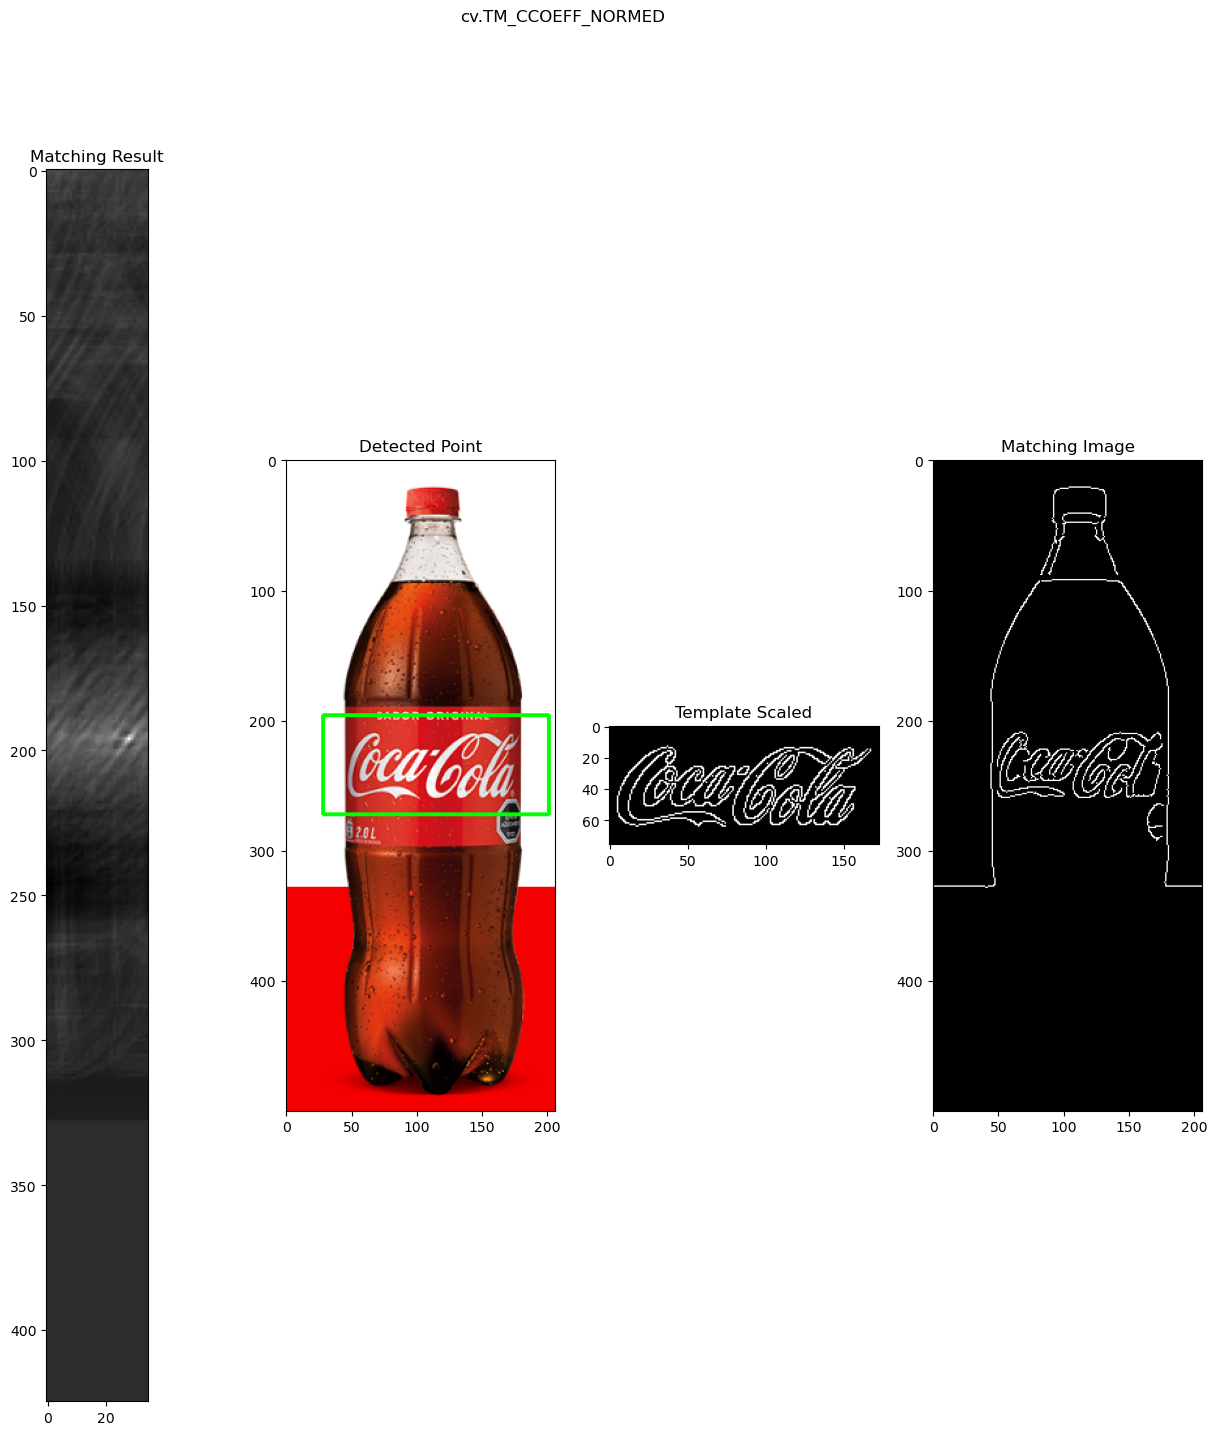

In [70]:
img = cv.imread('images/coca_logo_1.png')
res = encontrar_logo_coca(img)

#### coca_logo_2.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.12195024639368057
Tamaño Imagen Orig: (363, 233)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (97, 223)
Tamaño Imagen Scaled: (363, 233)


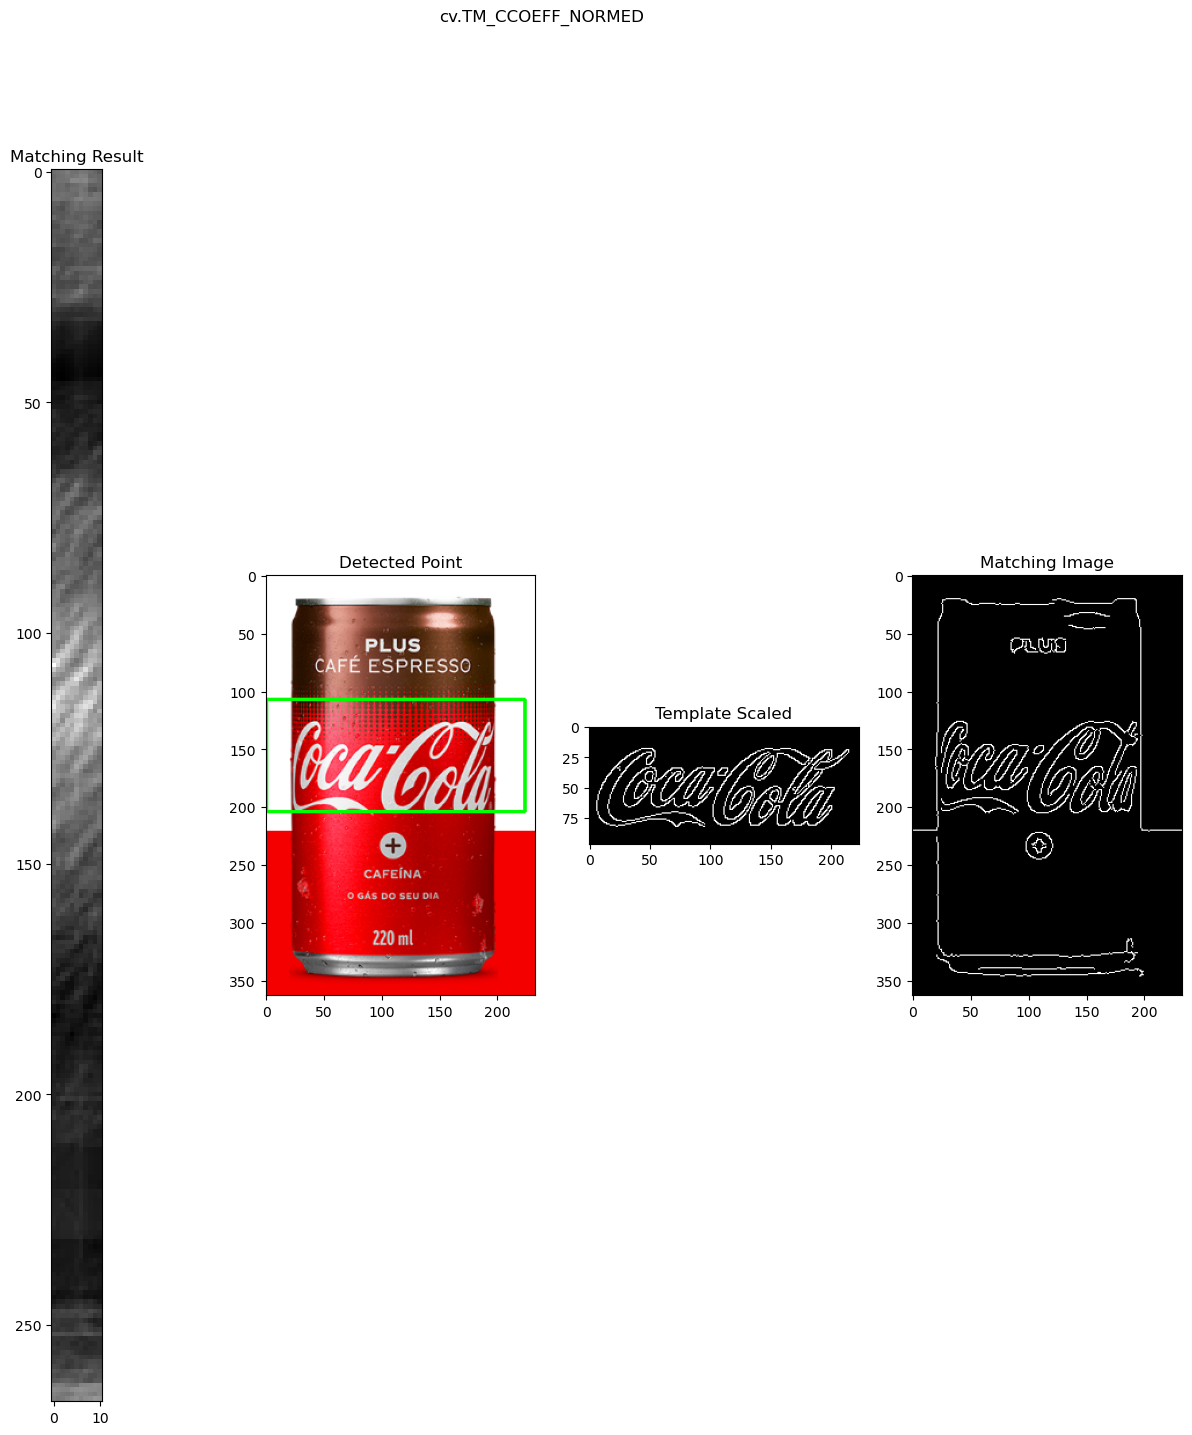

In [71]:
img = cv.imread('images/coca_logo_2.png')
res = encontrar_logo_coca(img)

#### coca_retro_1.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.1138119176030159
Tamaño Imagen Orig: (493, 715)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (70, 160)
Tamaño Imagen Scaled: (493, 715)


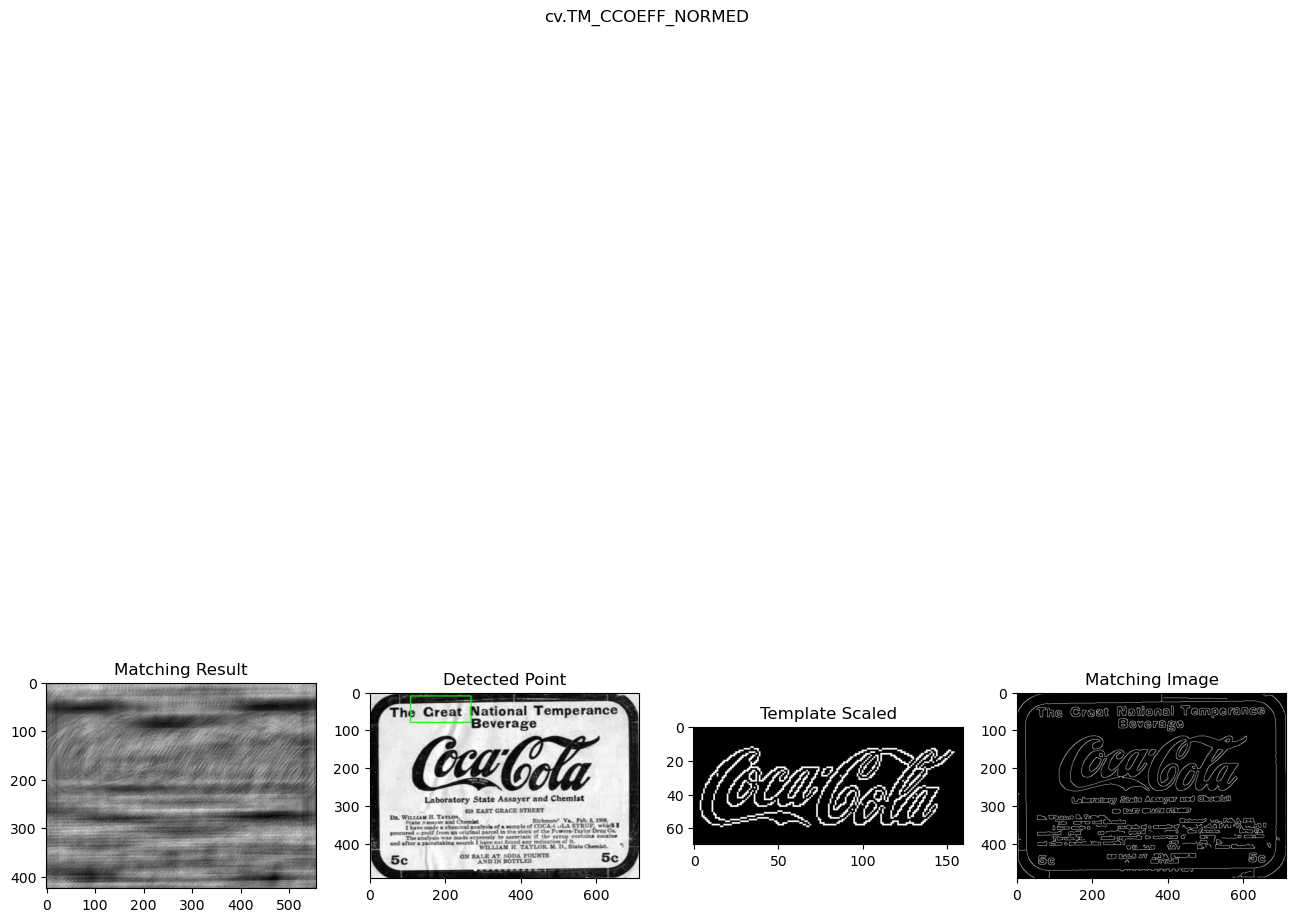

In [87]:
img = cv.imread('images/coca_retro_1.png')
res = encontrar_logo_coca(img)

#### coca_retro_2

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.27055105566978455
Tamaño Imagen Orig: (429, 715)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (70, 160)
Tamaño Imagen Scaled: (429, 715)


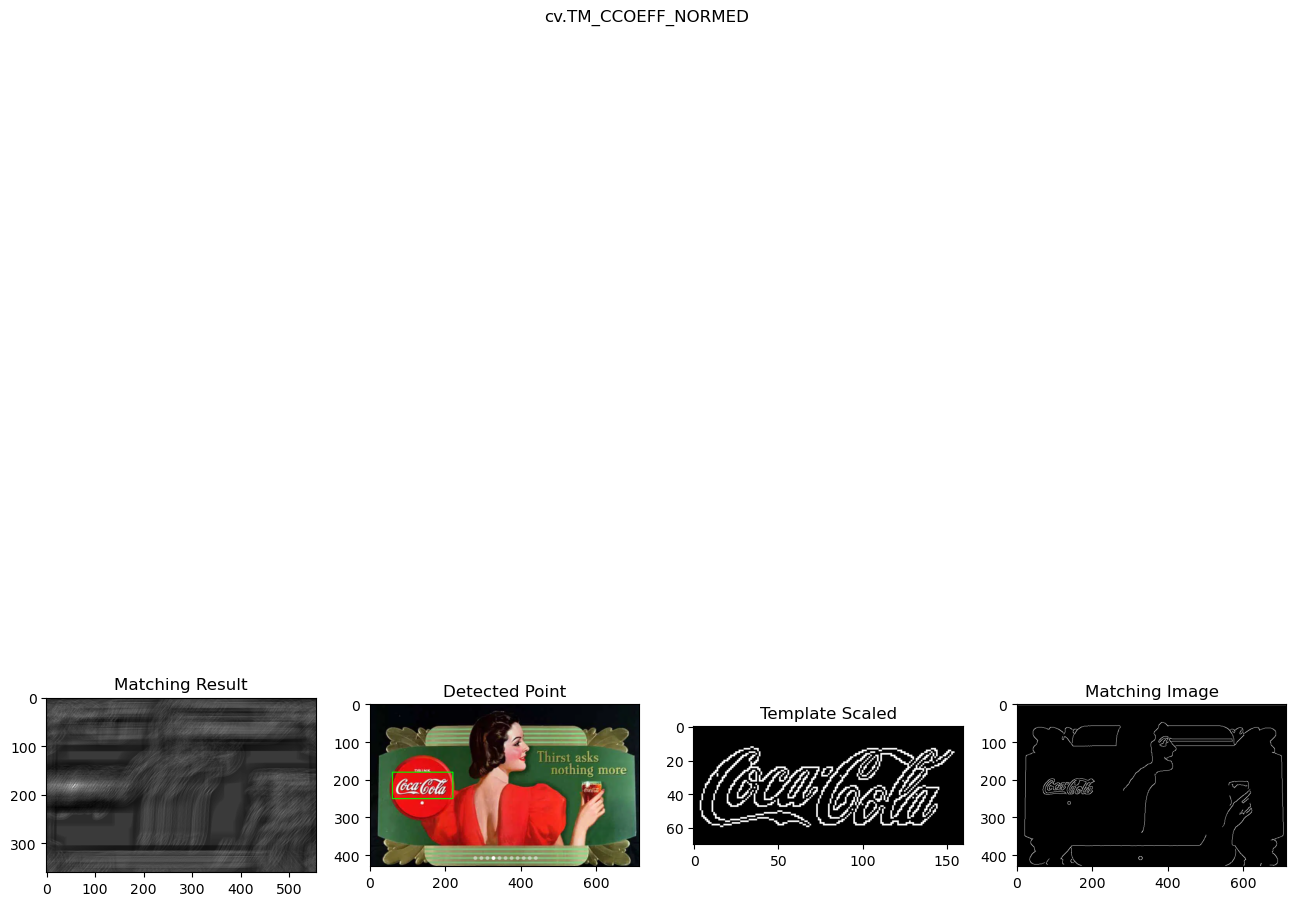

In [73]:
img = cv.imread('images/coca_retro_2.png')
res = encontrar_logo_coca(img)

#### COCA-COLA-LOGO.jpg

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.1786903589963913
Tamaño Imagen Orig: (278, 278)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (107, 244)
Tamaño Imagen Scaled: (278, 278)


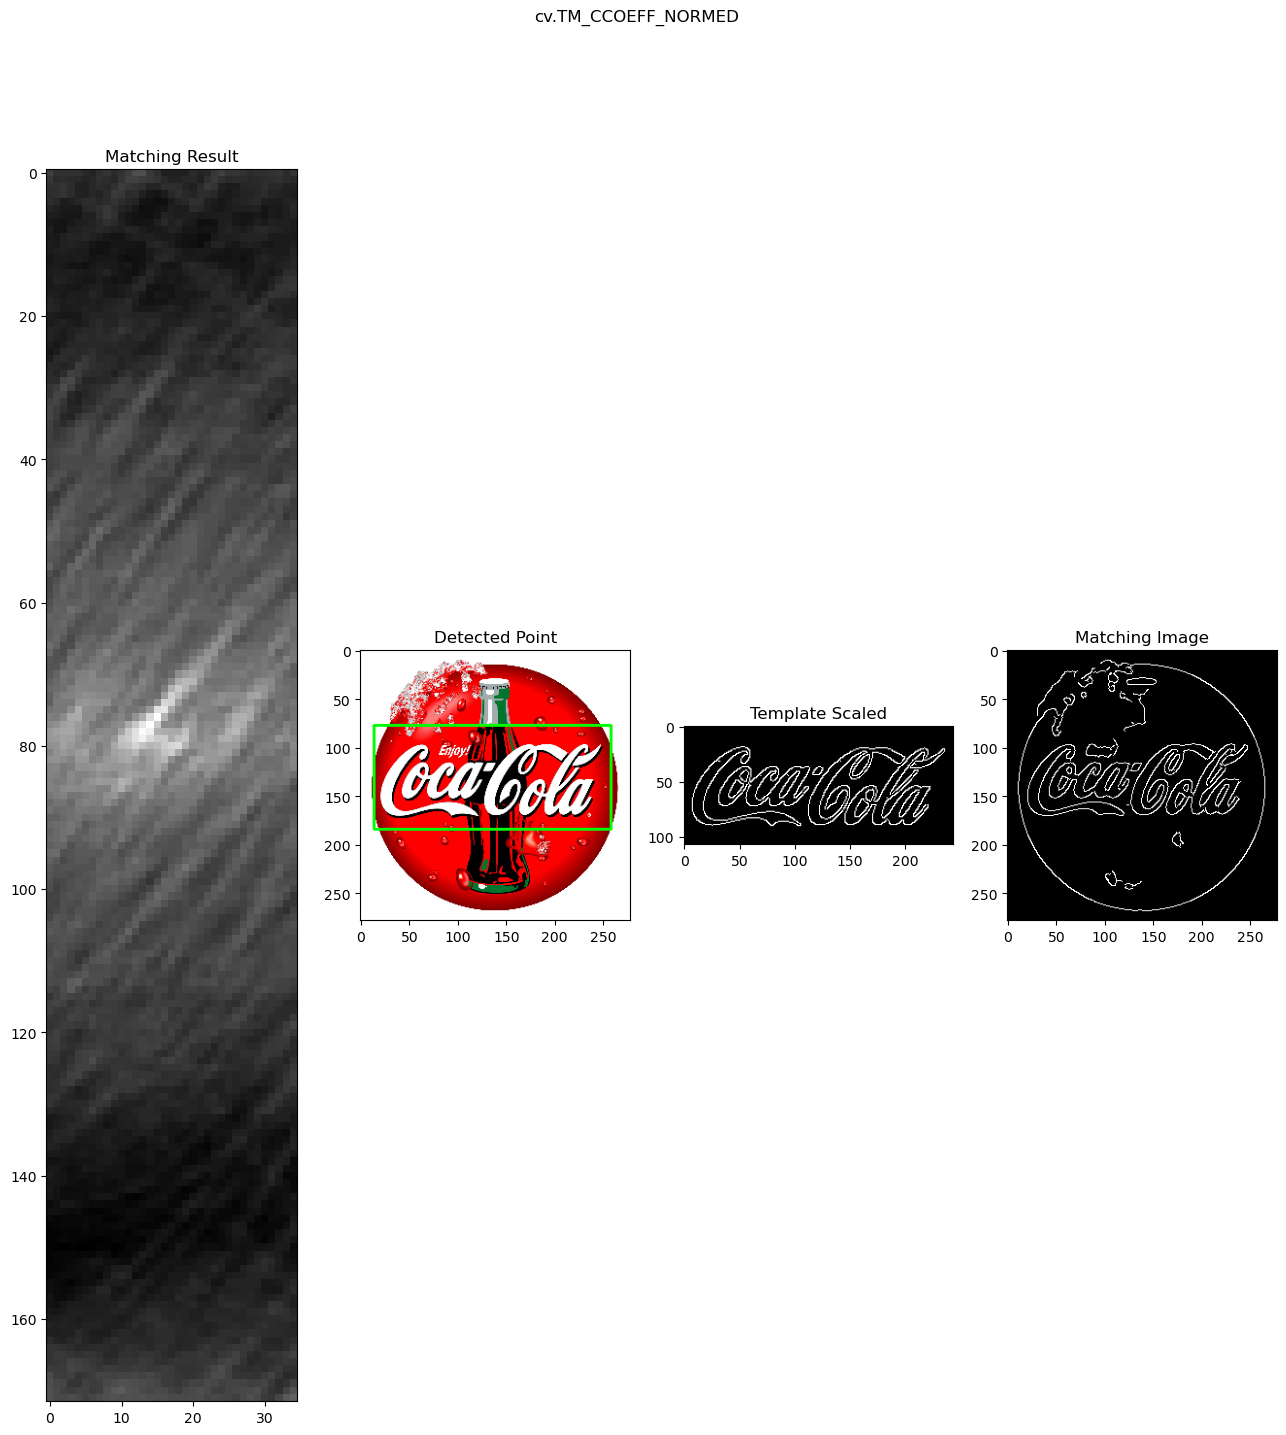

In [90]:
img = cv.imread('images/COCA-COLA-LOGO.jpg')
img = cv.resize(img, None, fx=0.2, fy=0.2)
res = encontrar_logo_coca(img)

#### logo_1.png

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.10754279047250748
Tamaño Imagen Orig: (450, 687)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (136, 311)
Tamaño Imagen Scaled: (450, 687)


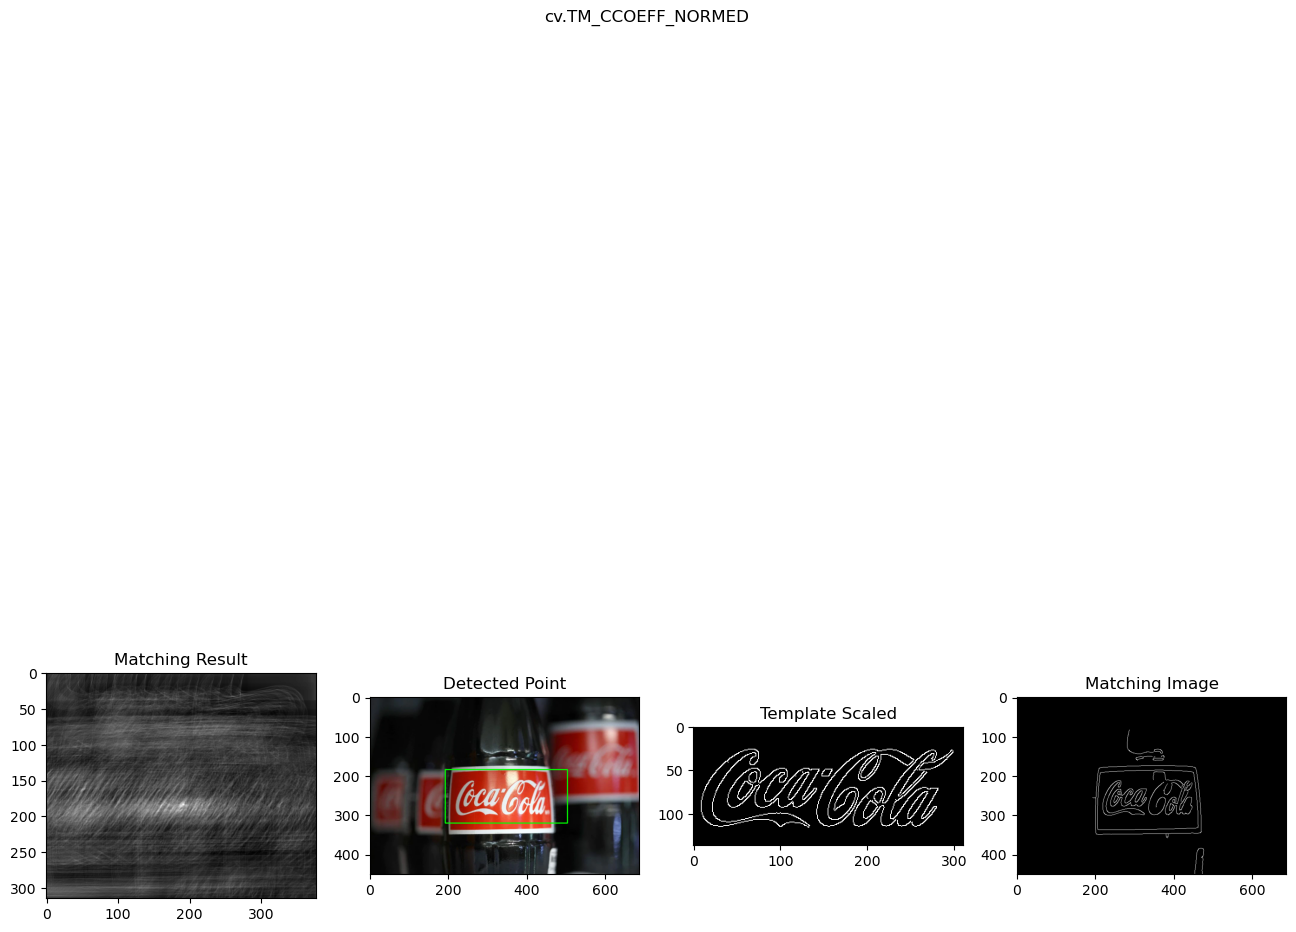

In [75]:
img = cv.imread('images/logo_1.png')
res = encontrar_logo_coca(img)

## Inciso 2

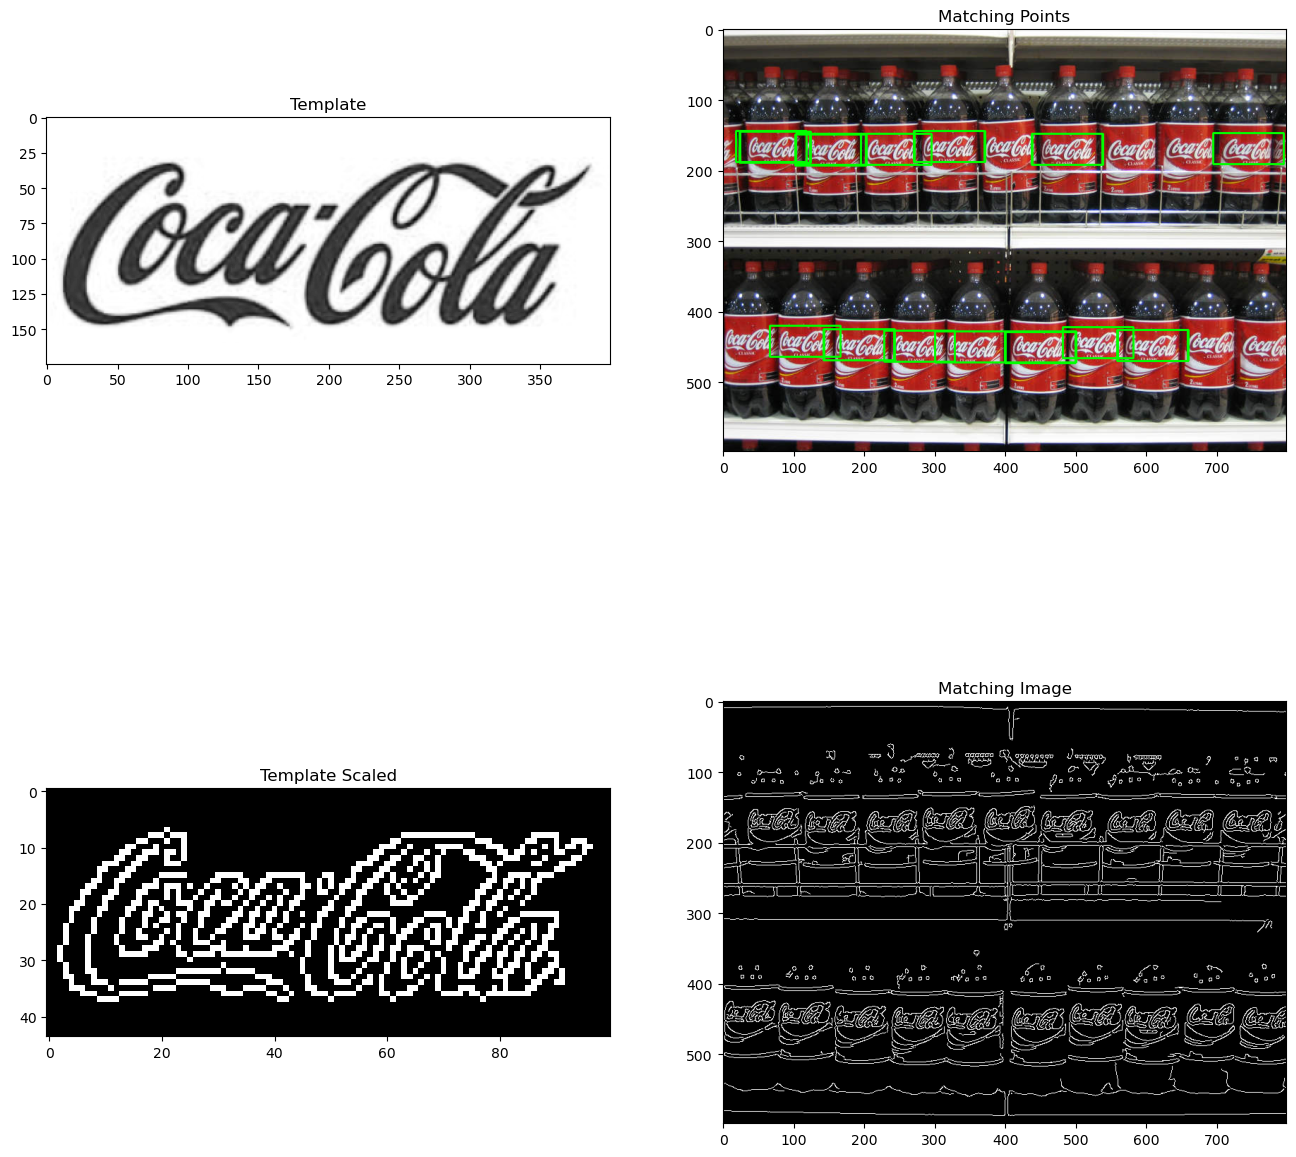

In [76]:
img       = cv.imread('images/coca_multi.png')
img_rgb    = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)

template_orig = cv.imread('template/pattern.png',0)

# Hago un resize del template al tamaño óptimo
template = cv.resize(template_orig, (100, 44))

k_size = 5
sigma_blur = 2


# Aplico filtro gaussiano a la imagen
img_blured = cv.GaussianBlur(img_gray, ksize=(k_size,k_size),
                             sigmaX=sigma_blur, sigmaY=sigma_blur)

# Aplico Canny a template e imagen
template   = cv.Canny(template, threshold1=5, threshold2=200)
img_blured = cv.Canny(img_blured, threshold1=5, threshold2=200)


w, h = template.shape[::-1]
res = cv.matchTemplate(img_blured,template,cv.TM_CCOEFF_NORMED)
# Fijamos un umbral de "coincidencia"
threshold = 0.15

min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

# cv.rectangle(img_rgb,top_left, bottom_right, 255, 2)

loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)

# cv.imshow("template",template)
# cv.imshow("cocas",img_rgb)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(template_orig, cmap='gray')
plt.title('Template')
plt.subplot(222)
plt.imshow(img_rgb)
plt.title('Matching Points')
plt.subplot(223)
plt.imshow(template, cmap='gray')
plt.title('Template Scaled')
plt.subplot(224)
plt.imshow(img_blured, cmap='gray')
plt.title('Matching Image')


cv.waitKey()
cv.destroyAllWindows()

## Inciso 3

----------------------------------------------------------------------------------------------------
Valor Obtenido por el método cv.TM_CCOEFF_NORMED = 0.2152160406112671
Tamaño Imagen Orig: (598, 799)
Tamaño Template Orig: (175, 400)
Tamaño Template Scaled: (44, 100)
Tamaño Imagen Scaled: (598, 799)


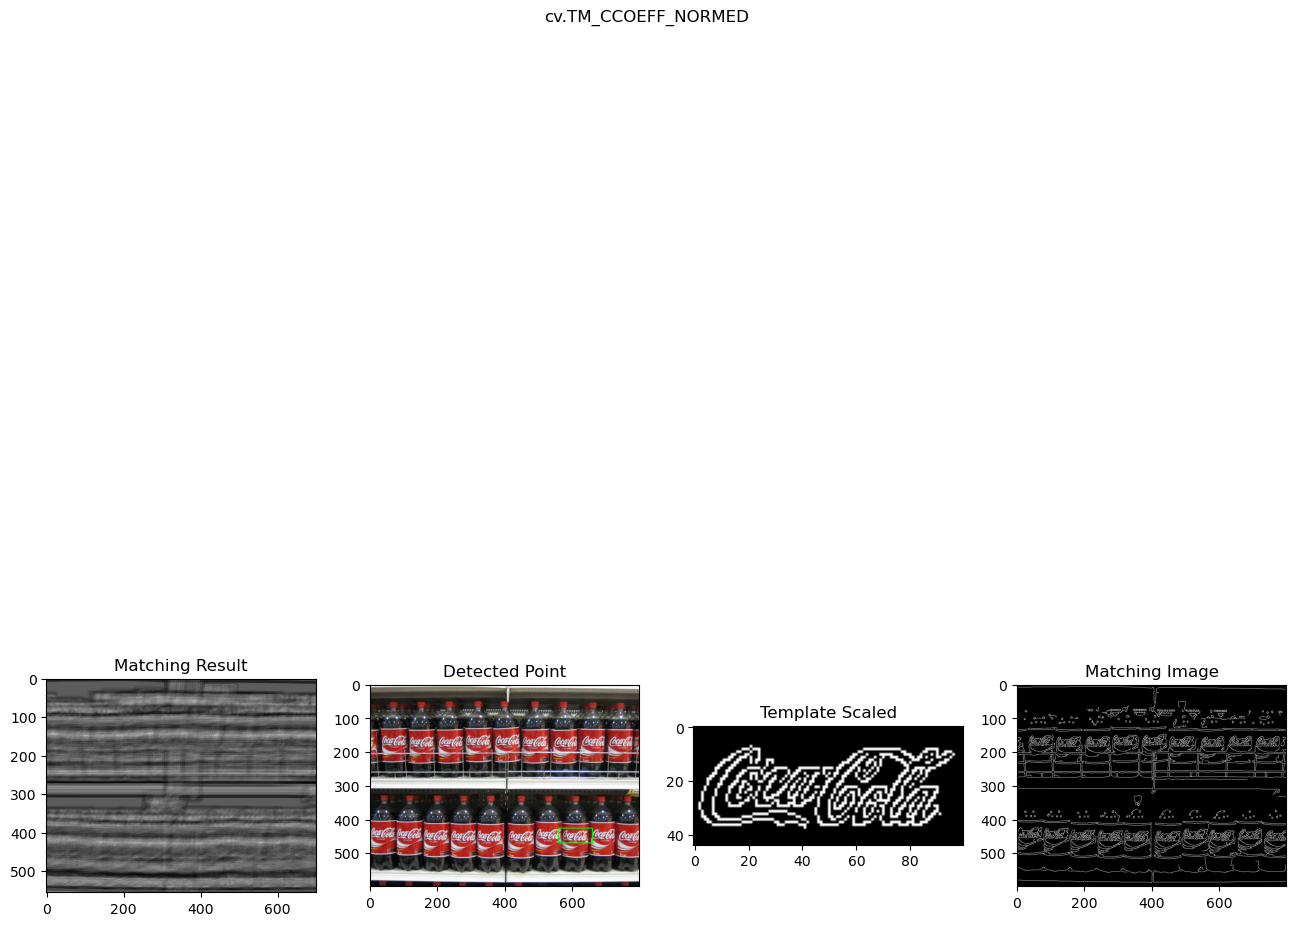

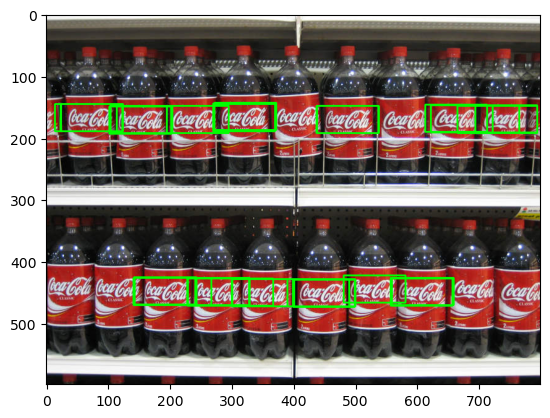

In [85]:
img = cv.imread('images/coca_multi.png')
img_rgb    = cv.cvtColor(img, cv.COLOR_BGR2RGB)
res2 = encontrar_logo_coca(img, min_sf=0.25, k_blur=5)
threshold = 0.15

loc = np.where( res2 >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,0), 2)

plt.imshow(img_rgb)

cv.waitKey()
cv.destroyAllWindows()